In [1]:
import os
import time
import torch

import utils
import dataset
import metrics

import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import constants as cst

In [2]:
plot_name = "Performances of the model for different thresholds"

model0 = "vc_Dice_Fold_0_Epoch_246_MaxEpochs_250_Adam_LR_0.0001.pth"
model1 = "vc_Dice_Fold_1_Epoch_248_MaxEpochs_250_Adam_LR_0.0001.pth"
model2 = "vc_Dice_Fold_2_Epoch_249_MaxEpochs_250_Adam_LR_0.0001.pth"
model3 = "vc_Dice_Fold_3_Epoch_247_MaxEpochs_250_Adam_LR_0.0001.pth"
model4 = "vc_Dice_Fold_4_Epoch_249_MaxEpochs_250_Adam_LR_0.0001.pth"

models = [model0, model1, model2, model3, model4]
#models = [model0]

images = ["1202220_4xzoom_v_fish 09.jpg",
          "1202220_4xzoom_v1_fish 11.jpg",
          "1202220_4xzoom_v_fish 23.jpg"]

DEVICE_NAME = "cpu"
if torch.cuda.is_available():
    DEVICE_NAME = 'cuda:0'
DEVICE = torch.device(DEVICE_NAME)

term = "vc"
crop = False

thresholds = np.linspace(0, 1, num=51)
"""thresholds = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
              0.1, 0.11, 0.12, 0.13, 0.14, 0.5, 1]"""
#thresholds = [0.09, 0.5]

fold = 0
image_folder = "/notebooks/images"
mask_folder = "/notebooks/" + term

if crop:
    model_name = "fish_CE_Fold_4_Epoch_95_MaxEpochs_600_Adam_LR_0.0001.pth"
    model_path = os.path.join(cst.MODEL, model_name)

    model = utils.load_model(model_path)
    model.to(DEVICE)
    
    testing_set = dataset.ZebrafishDataset_KFold_crop_head(image_folder,
                                                           mask_folder,
                                                           actual_fold=fold,
                                                           model = model,
                                                           device = DEVICE,
                                                           dataset="test",
                                                           folds = cst.FOLDS)    
else:
    testing_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                     mask_folder,
                                                     actual_fold=fold,
                                                     dataset="test",
                                                     folds=cst.FOLDS)
    
testing_loader = torch.utils.data.DataLoader(testing_set,
                                             batch_size=1,
                                             shuffle=True,
                                             num_workers=cst.WORKERS)

Testing set length: 20


In [3]:
def predict_img(model, image, device, transform, out_threshold=0.5):
    with torch.no_grad():
        x = image
        logits = model(x.to(device))
        logits = transform(logits)
        y_pred = nn.Softmax(dim=1)(logits)
        proba = y_pred.detach().cpu().squeeze(0).numpy()[1, :, :]
        return proba > out_threshold
    
def evaluate(eval_model, testing_loader, threshold):
    names = ["120220_4xzoom_v_fish 09.jpg",
              "120220_4xzoom_v1_fish 11.jpg",
              "120220_4xzoom_v_fish 23.jpg"]
    tps = 0
    precisions = []
    recalls = []
    F1s = []
    IOUs = []
    
    SIZE = (384, 512)
    
    transform = transforms.Compose([transforms.Resize(SIZE),
                                    transforms.Pad((0, 64, 0, 64))])
    untransform = transforms.Compose([transforms.CenterCrop(SIZE),
                                     transforms.Resize((1932, 2576))])

    eval_model.eval()
    for image, mask, name in testing_loader:
        
        prediction = utils.predict_img(eval_model, transform(image), DEVICE, untransform, out_threshold=threshold)
        pred = torch.from_numpy(prediction)
        if threshold >0.49 and threshold<0.51:
            print("Pred")
            plt.imshow(pred.squeeze().cpu())
            plt.show()
        
        """print(name[0])
        if name[0] in names:
            print("Mask")
            plt.imshow(mask.squeeze().cpu())
            plt.show()
            print("Pred")
            plt.imshow(pred.squeeze().cpu())
            plt.show()"""

        precisions.append(metrics.precision(pred, mask))
        recalls.append(metrics.recall(pred, mask))
        F1s.append(metrics.F1Score(pred, mask))
        IOUs.append(metrics.IOUScore(pred, mask))
    return precisions, recalls, F1s, IOUs

def evaluate_crop(eval_model, testing_loader, threshold):
    tps = 0
    precisions = []
    recalls = []
    F1s = []
    IOUs = []
    
    names = ["120220_4xzoom_v_fish 09.jpg",
              "120220_4xzoom_v1_fish 11.jpg",
              "120220_4xzoom_v_fish 23.jpg"]
    
    eval_model.eval()
    for image, mask, name, size in testing_loader:
        h_length = int(size[0])
        v_length = int(size[1])
        if h_length>v_length:
            untr = transforms.Compose([transforms.Resize((h_length, h_length)),
                                       transforms.CenterCrop((v_length, h_length))])
        elif h_length<v_length:
            untr = transforms.Compose([transforms.Resize((v_length, v_length)),
                                       transforms.CenterCrop((v_length, h_length))])
        else:
            untr = transforms.Compose([transforms.Resize((h_length, h_length))])

        image_name = name[0]
        
        prediction = utils.predict_img(eval_model, image, DEVICE, untr, out_threshold=threshold)
        pred = torch.from_numpy(prediction)
        """pr = pred * 1
        pr = pr.unsqueeze(dim=0)
        show_images(pr)"""

        mask = untr(mask)
        
        print(name[0])
        if name[0] in names:
            print("Mask")
            plt.imshow(mask.squeeze().cpu())
            plt.show()
            print("Pred")
            plt.imshow(pred.squeeze().cpu())
            plt.show()

        precisions.append(metrics.precision(pred, mask))
        recalls.append(metrics.recall(pred, mask))
        F1s.append(metrics.F1Score(pred, mask))
        IOUs.append(metrics.IOUScore(pred, mask))
    return precisions, recalls, F1s, IOUs

Threshold: 0.0
Threshold: 0.02
Threshold: 0.04
Threshold: 0.06
Threshold: 0.08
Threshold: 0.1
Threshold: 0.12
Threshold: 0.14
Threshold: 0.16
Threshold: 0.18
Threshold: 0.2
Threshold: 0.22
Threshold: 0.24
Threshold: 0.26
Threshold: 0.28
Threshold: 0.3
Threshold: 0.32
Threshold: 0.34
Threshold: 0.36
Threshold: 0.38
Threshold: 0.4
Threshold: 0.42
Threshold: 0.44
Threshold: 0.46
Threshold: 0.48
Threshold: 0.5
Pred


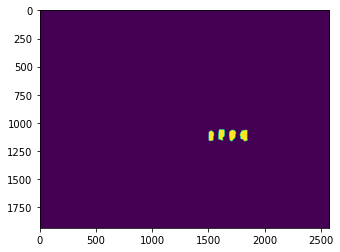

Pred


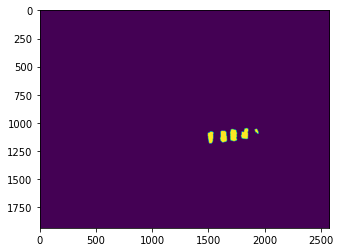

Pred


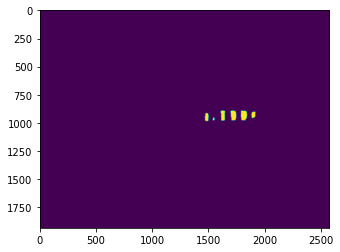

Pred


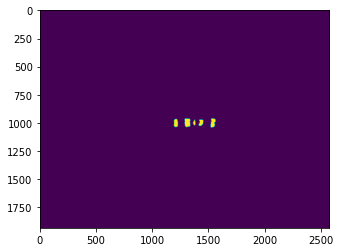

Pred


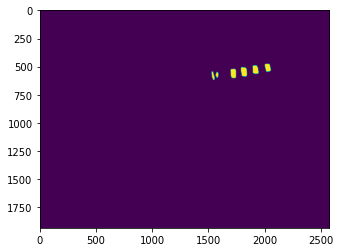

Pred


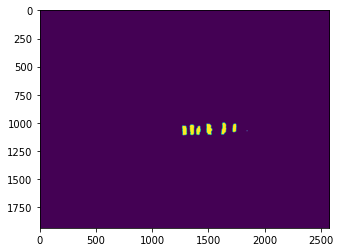

Pred


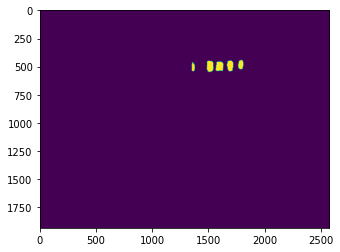

Pred


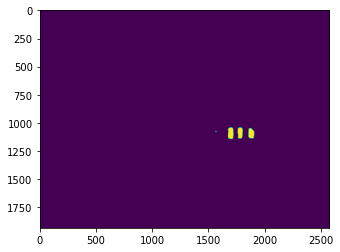

Pred


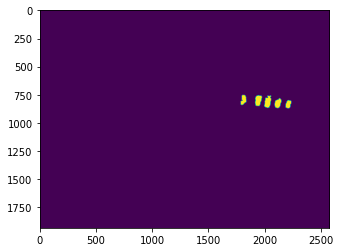

Pred


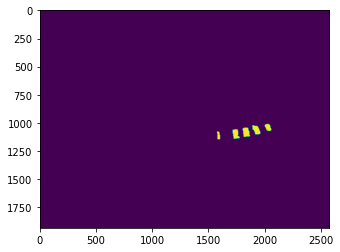

Pred


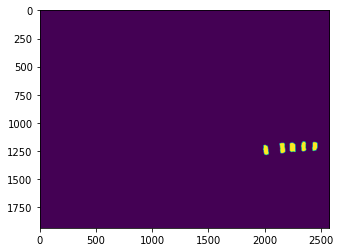

Pred


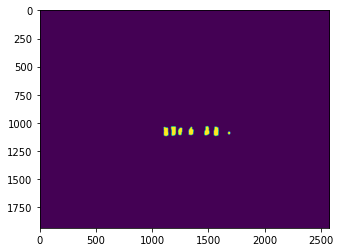

Pred


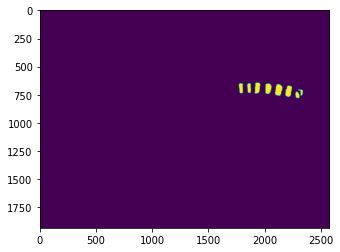

Pred


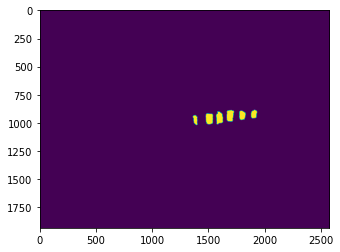

Pred


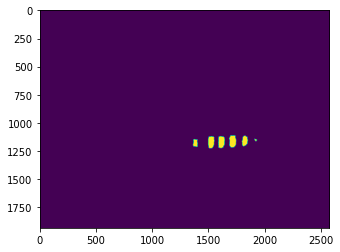

Pred


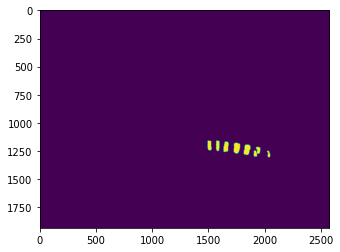

Pred


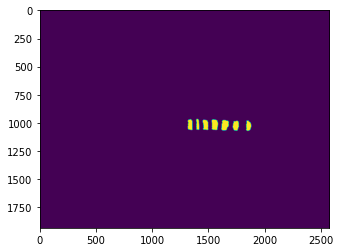

Pred


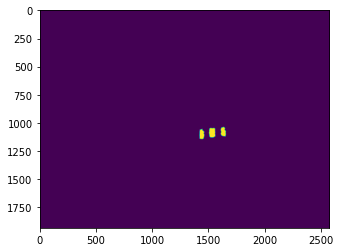

Pred


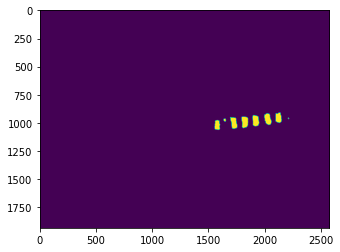

Pred


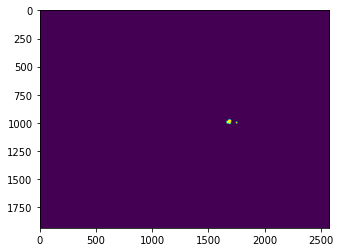

Pred


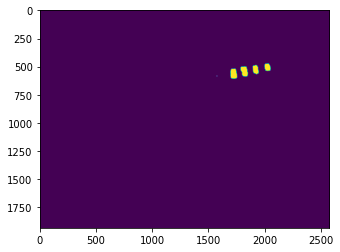

Pred


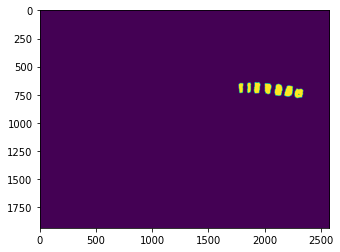

Pred


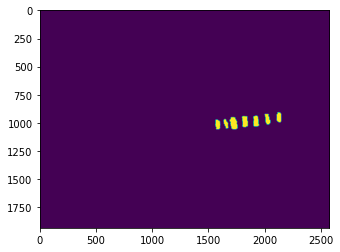

Pred


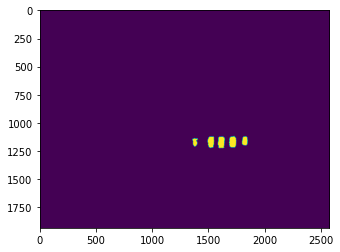

Pred


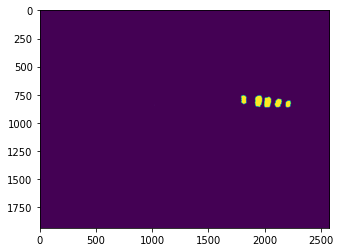

Pred


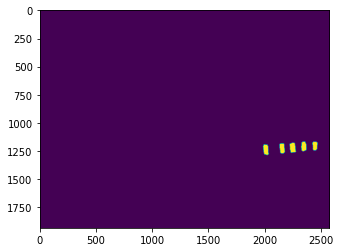

Pred


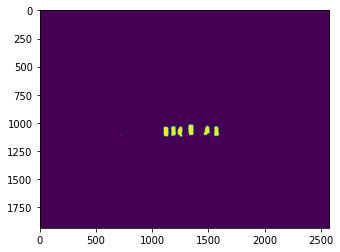

Pred


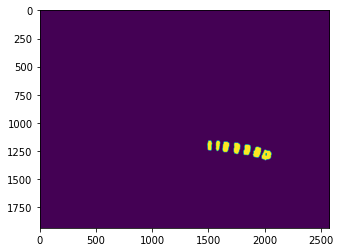

Pred


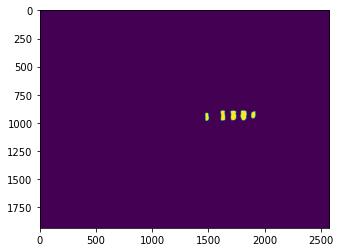

Pred


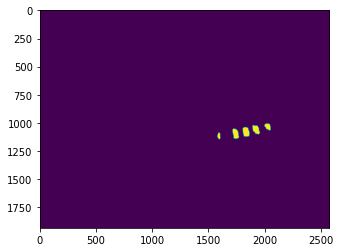

Pred


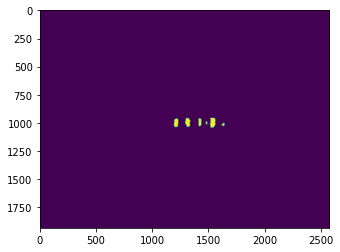

Pred


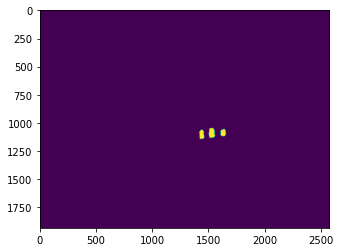

Pred


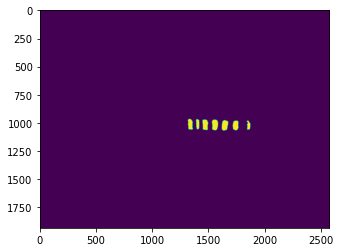

Pred


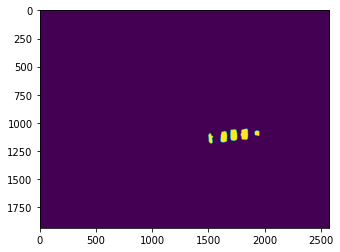

Pred


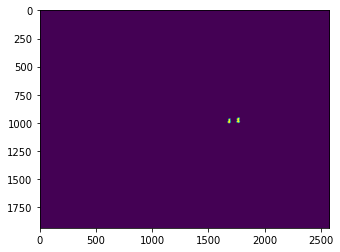

Pred


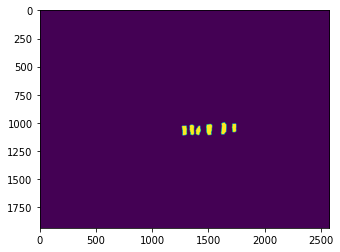

Pred


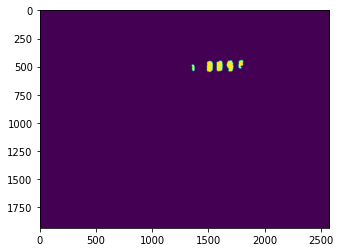

Pred


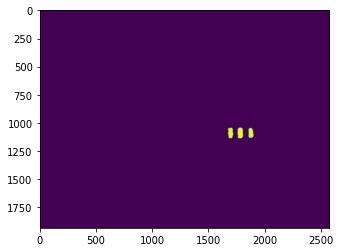

Pred


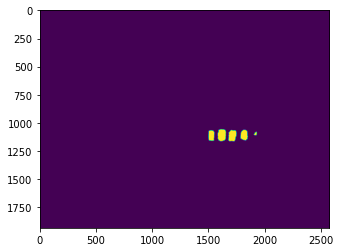

Pred


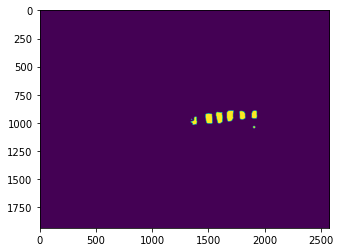

Pred


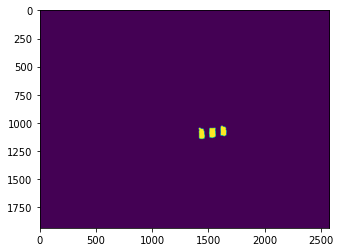

Pred


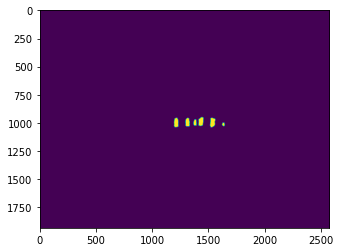

Pred


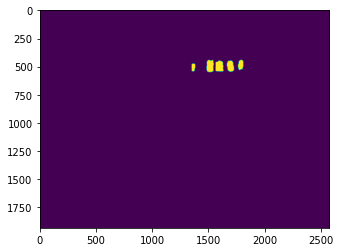

Pred


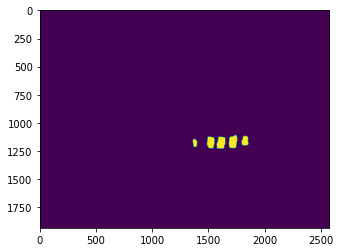

Pred


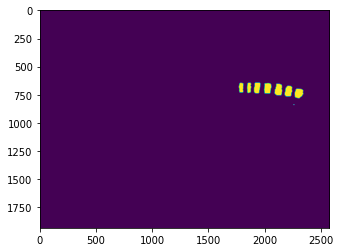

Pred


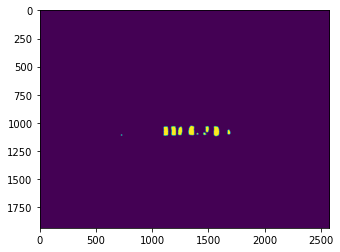

Pred


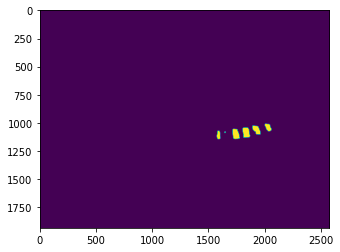

Pred


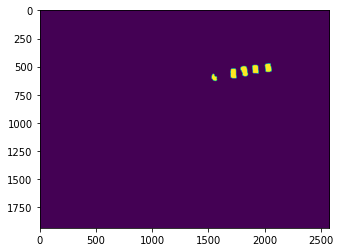

Pred


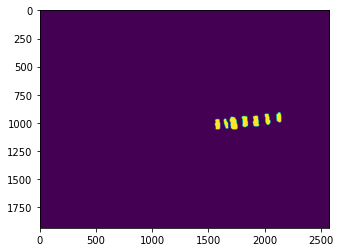

Pred


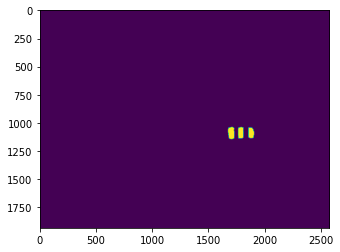

Pred


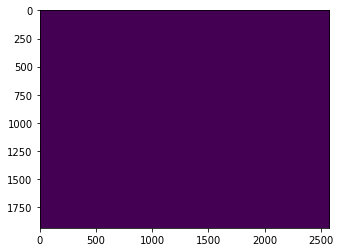

Pred


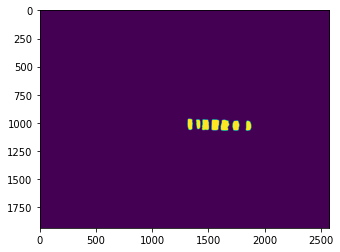

Pred


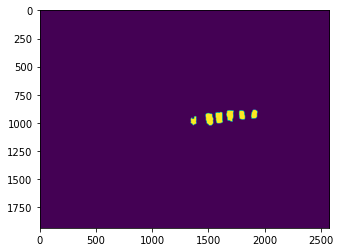

Pred


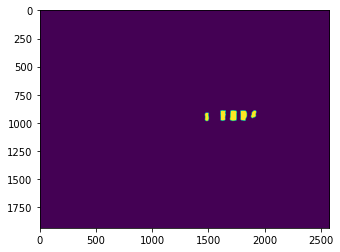

Pred


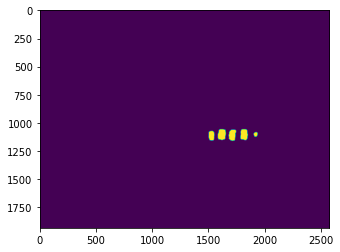

Pred


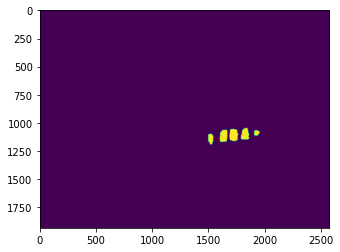

Pred


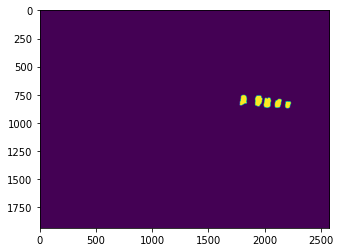

Pred


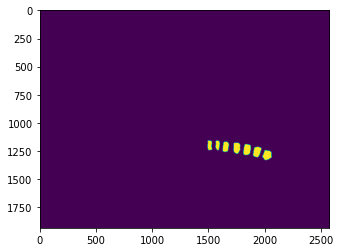

Pred


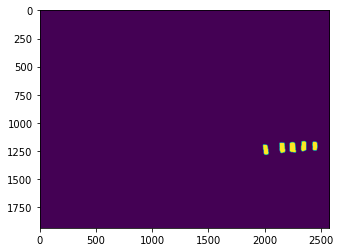

Pred


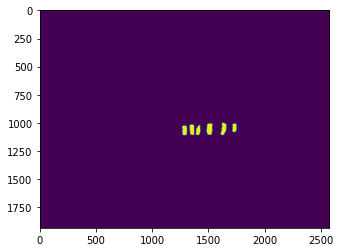

Pred


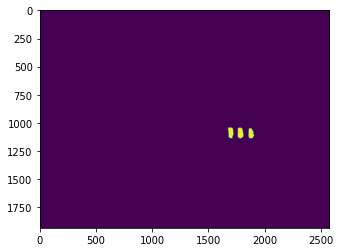

Pred


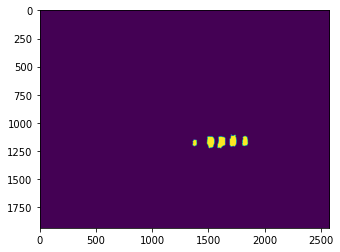

Pred


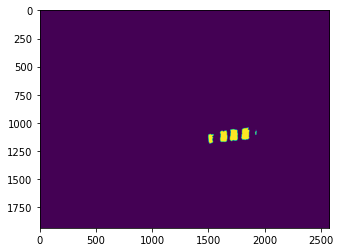

Pred


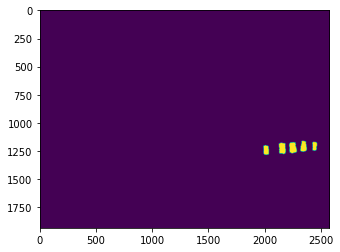

Pred


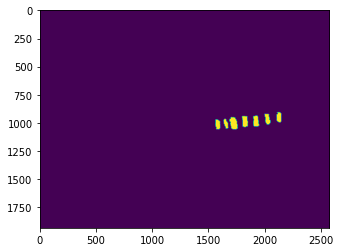

Pred


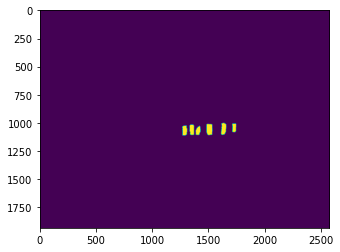

Pred


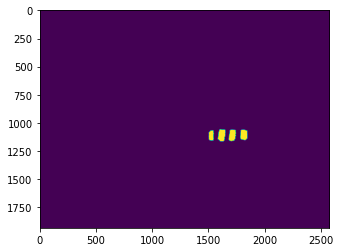

Pred


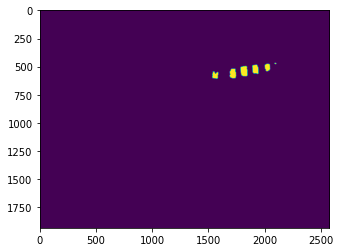

Pred


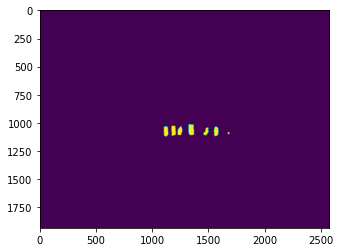

Pred


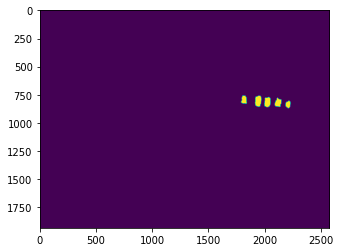

Pred


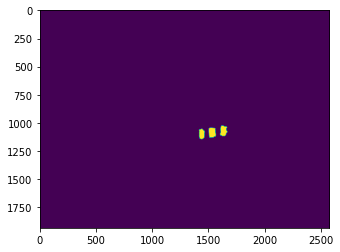

Pred


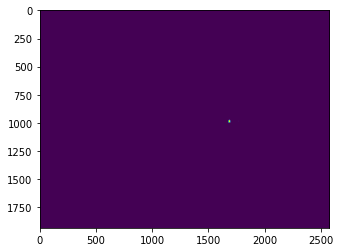

Pred


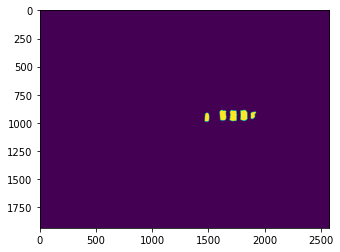

Pred


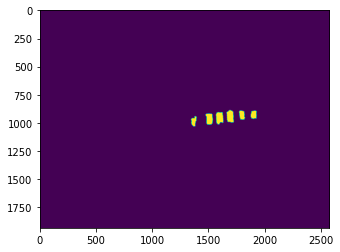

Pred


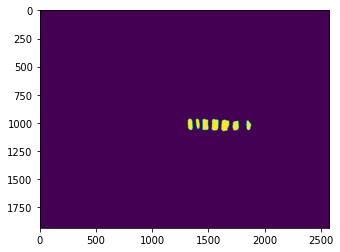

Pred


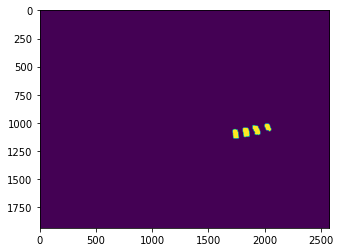

Pred


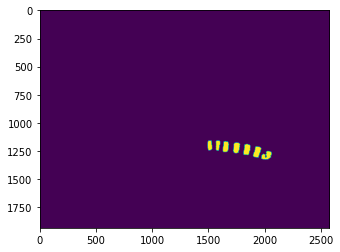

Pred


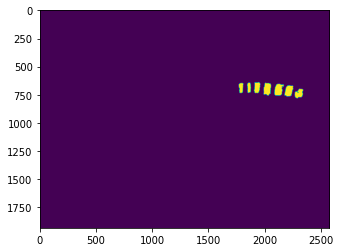

Pred


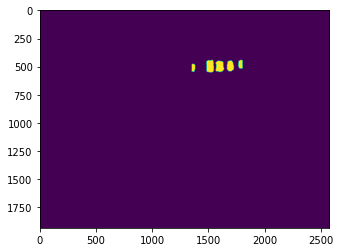

Pred


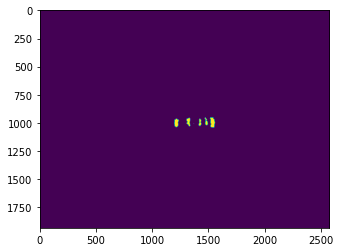

Pred


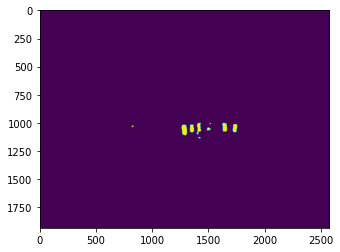

Pred


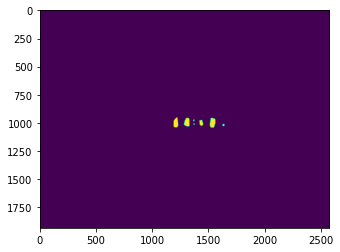

Pred


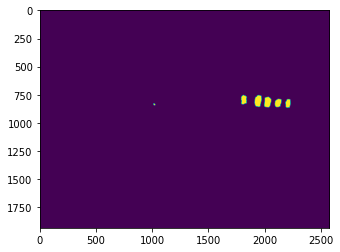

Pred


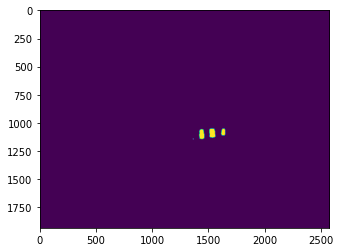

Pred


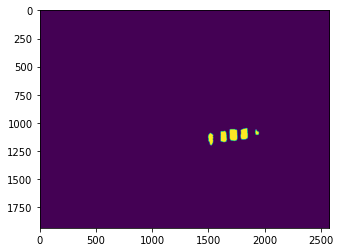

Pred


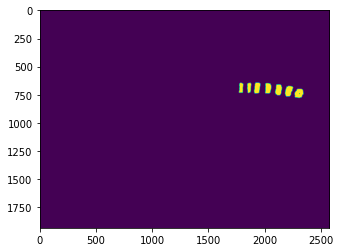

Pred


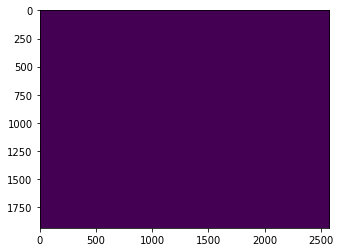

Pred


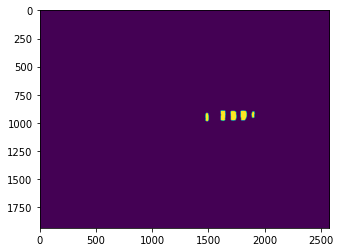

Pred


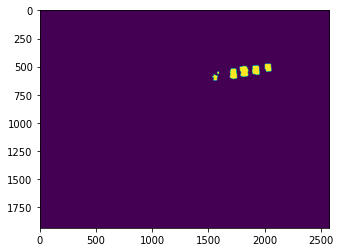

Pred


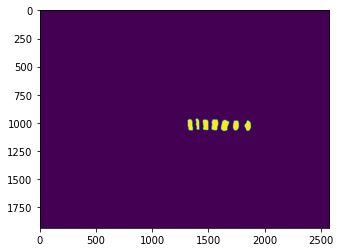

Pred


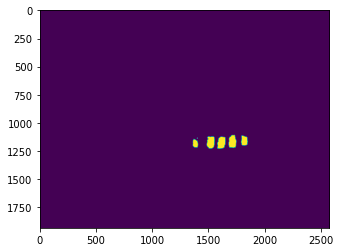

Pred


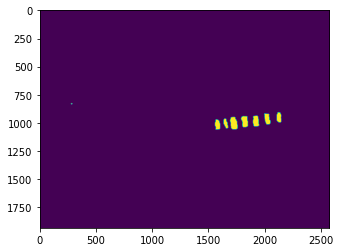

Pred


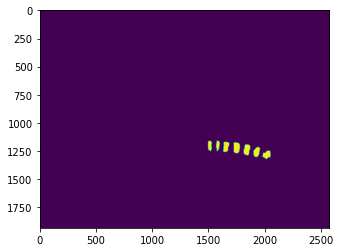

Pred


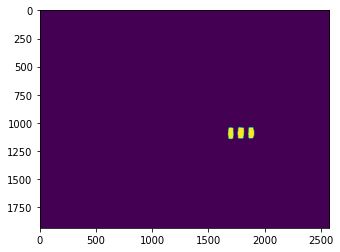

Pred


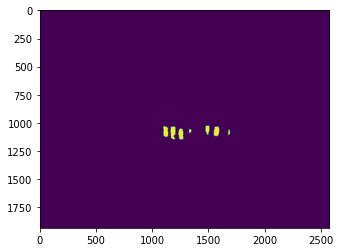

Pred


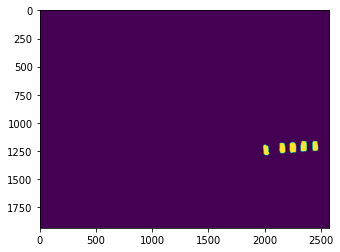

Pred


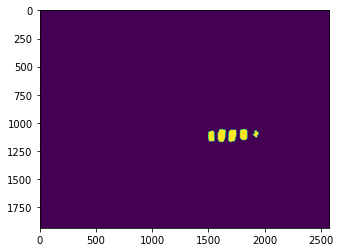

Pred


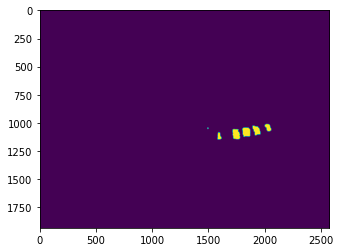

Pred


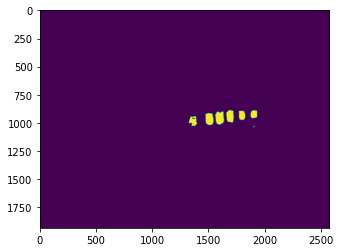

Pred


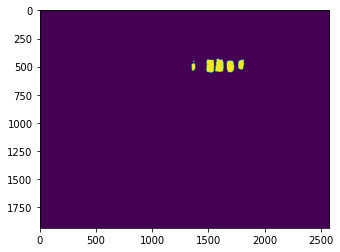

Threshold: 0.52
Threshold: 0.54
Threshold: 0.56
Threshold: 0.58
Threshold: 0.6
Threshold: 0.62
Threshold: 0.64
Threshold: 0.66
Threshold: 0.68
Threshold: 0.7000000000000001
Threshold: 0.72
Threshold: 0.74
Threshold: 0.76
Threshold: 0.78
Threshold: 0.8
Threshold: 0.8200000000000001
Threshold: 0.84
Threshold: 0.86
Threshold: 0.88
Threshold: 0.9
Threshold: 0.92
Threshold: 0.9400000000000001
Threshold: 0.96
Threshold: 0.98
Threshold: 1.0


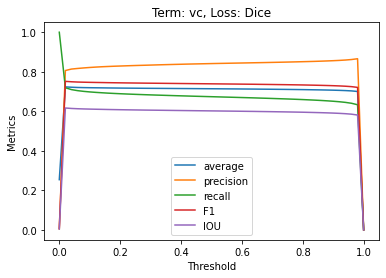

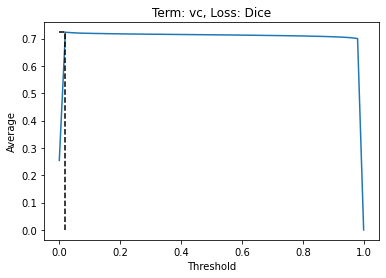

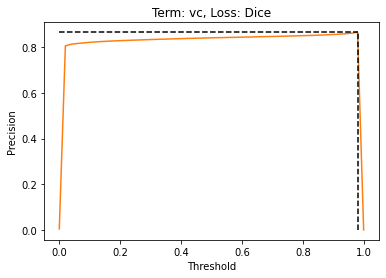

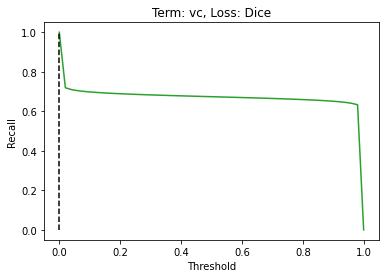

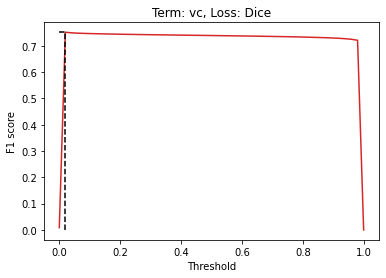

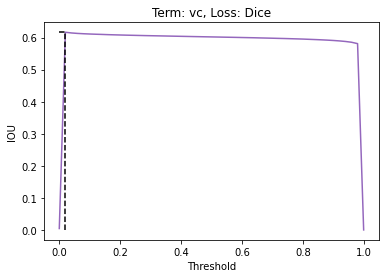

The threshold providing the best average performances is: 0.02
Average: 0.7234604128543218
Precision: 0.8063622706406128
Recall: 0.7192136143060518
F1: 0.7515656555416563
IOUs: 0.6167001109289665

The threshold providing the best precision is: 0.98
Average: 0.7003643074938183
Precision: 0.8659922955973893
Recall: 0.6332332874505018
F1: 0.721040195819539
IOUs: 0.581191451107843

The threshold providing the best recall is: 0.0
Average: 0.25431774856191025
Precision: 0.004328449429257012
Recall: 0.9999999999991249
F1: 0.00861409539000194
IOUs: 0.004328449429257012

The threshold providing the best F1 is: 0.02
Average: 0.7234604128543218
Precision: 0.8063622706406128
Recall: 0.7192136143060518
F1: 0.7515656555416563
IOUs: 0.6167001109289665

The threshold providing the best IOU is: 0.02
Average: 0.7234604128543218
Precision: 0.8063622706406128
Recall: 0.7192136143060518
F1: 0.7515656555416563
IOUs: 0.6167001109289665

Computing time: 28.0 minutes 29.85739278793335


In [4]:
start = time.time()
precisions = []
recalls = []
F1s = []
IOUs = []

for threshold in thresholds:
    print("Threshold: " + str(threshold))
    
    m_precision = []
    m_recall = []
    m_f1 = []
    m_iou = []
    
    for model_name in models:
        model_path = os.path.join(cst.DIR, "vc_normal", model_name)
        if crop:
            model = utils.load_k5_model(model_path) #
        else:
            model = utils.load_model(model_path)
        model.to(DEVICE)
        
        if crop:
            p,r,f,i = evaluate_crop(model, testing_loader, threshold)           
        else:
            p,r,f,i = evaluate(model, testing_loader, threshold)
            
        m_precision.append(np.mean(p))
        m_recall.append(np.mean(r))
        m_f1.append(np.mean(f))
        m_iou.append(np.mean(i))
    
    precisions.append(np.mean(m_precision))
    recalls.append(np.mean(m_recall))
    F1s.append(np.mean(m_f1))
    IOUs.append(np.mean(m_iou))
    
means = []
for i in range(51):
    m = (precisions[i]+recalls[i]+F1s[i]+IOUs[i])/4
    means.append(m)
    
    
TERM = "vc"
loss_name = "Dice"
run_name = TERM + "_normal"
dir_name = os.path.join(cst.DIR, run_name)

    
plt.plot(thresholds, means , label="average", color="tab:blue")
plt.plot(thresholds, precisions , label="precision", color="tab:orange")
plt.plot(thresholds, recalls, label="recall", color="tab:green")
plt.plot(thresholds, F1s, label="F1", color="tab:red")
plt.plot(thresholds, IOUs, label="IOU", color="tab:purple")
plt.ylabel("Metrics")
plt.xlabel("Threshold")
plt.title("Term: " + TERM + ", Loss: " + loss_name)
plt.legend()
plt.savefig(os.path.join(dir_name, TERM + "_" + loss_name + "_Metric_curves.jpg"))
plt.show()

best = np.argmax(means)
plt.plot(thresholds, means , label="average", color="tab:blue")
plt.vlines(thresholds[best], 0, means[best], colors="black",linestyles="dashed")
plt.hlines(means[best], 0, thresholds[best], colors="black",linestyles="dashed")
plt.ylabel("Average")
plt.xlabel("Threshold")
plt.title("Term: " + TERM + ", Loss: " + loss_name)
plt.savefig(os.path.join(dir_name, TERM + "_" + loss_name + "_average_curves.jpg"))
plt.show()

best = np.argmax(precisions)
plt.plot(thresholds, precisions , label="precision", color="tab:orange")
plt.vlines(thresholds[best], 0, precisions[best], colors="black",linestyles="dashed")
plt.hlines(precisions[best], 0, thresholds[best], colors="black",linestyles="dashed")
plt.ylabel("Precision")
plt.xlabel("Threshold")
plt.title("Term: " + TERM + ", Loss: " + loss_name)
plt.savefig(os.path.join(dir_name, TERM + "_" + loss_name + "_precision_curves.jpg"))
plt.show()

best = np.argmax(recalls)
plt.plot(thresholds, recalls, label="recall", color="tab:green")
plt.vlines(thresholds[best], 0, recalls[best], colors="black",linestyles="dashed")
plt.hlines(recalls[best], 0, thresholds[best], colors="black",linestyles="dashed")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.title("Term: " + TERM + ", Loss: " + loss_name)
plt.savefig(os.path.join(dir_name, TERM + "_" + loss_name + "_recall_curves.jpg"))
plt.show()

best = np.argmax(F1s)
plt.plot(thresholds, F1s, label="F1", color="tab:red")
plt.vlines(thresholds[best], 0, F1s[best], colors="black",linestyles="dashed")
plt.hlines(F1s[best], 0, thresholds[best], colors="black",linestyles="dashed")
plt.ylabel("F1 score")
plt.xlabel("Threshold")
plt.title("Term: " + TERM + ", Loss: " + loss_name)
plt.savefig(os.path.join(dir_name, TERM + "_" + loss_name + "_F1_curves.jpg"))
plt.show()

best = np.argmax(IOUs)
plt.plot(thresholds, IOUs, label="IOU", color="tab:purple")
plt.vlines(thresholds[best], 0, IOUs[best], colors="black",linestyles="dashed")
plt.hlines(IOUs[best], 0, thresholds[best], colors="black",linestyles="dashed")
plt.ylabel("IOU")
plt.xlabel("Threshold")
plt.title("Term: " + TERM + ", Loss: " + loss_name)
plt.savefig(os.path.join(dir_name, TERM + "_" + loss_name + "_IOU_curves.jpg"))
plt.show()

best = np.argmax(means)
print("The threshold providing the best average performances is: " + str(thresholds[best]))
print("Average: " + str(means[best]))
print("Precision: " + str(precisions[best]))
print("Recall: " + str(recalls[best]))
print("F1: " + str(F1s[best]))
print("IOUs: " + str(IOUs[best]))
print()

best = np.argmax(precisions)
print("The threshold providing the best precision is: " + str(thresholds[best]))
print("Average: " + str(means[best]))
print("Precision: " + str(precisions[best]))
print("Recall: " + str(recalls[best]))
print("F1: " + str(F1s[best]))
print("IOUs: " + str(IOUs[best]))
print()

best = np.argmax(recalls)
print("The threshold providing the best recall is: " + str(thresholds[best]))
print("Average: " + str(means[best]))
print("Precision: " + str(precisions[best]))
print("Recall: " + str(recalls[best]))
print("F1: " + str(F1s[best]))
print("IOUs: " + str(IOUs[best]))
print()

best = np.argmax(F1s)
print("The threshold providing the best F1 is: " + str(thresholds[best]))
print("Average: " + str(means[best]))
print("Precision: " + str(precisions[best]))
print("Recall: " + str(recalls[best]))
print("F1: " + str(F1s[best]))
print("IOUs: " + str(IOUs[best]))
print()

best = np.argmax(IOUs)
print("The threshold providing the best IOU is: " + str(thresholds[best]))
print("Average: " + str(means[best]))
print("Precision: " + str(precisions[best]))
print("Recall: " + str(recalls[best]))
print("F1: " + str(F1s[best]))
print("IOUs: " + str(IOUs[best]))
print()

curr = time.time()
curr = curr - start
secondes = curr % 60
minutes = (curr-secondes)/60
print("Computing time: " + str(minutes) + " minutes " + str(secondes))